# Future Food Production

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Import-useful-librairies" data-toc-modified-id="Import-useful-librairies-0.0.1">Import useful librairies</a></span></li></ul></li></ul></li><li><span><a href="#1.-Data-Exploration" data-toc-modified-id="1.-Data-Exploration-1">1. Data Exploration</a></span><ul class="toc-item"><li><span><a href="#1.1.-2000-data:-output-and-feature-distances" data-toc-modified-id="1.1.-2000-data:-output-and-feature-distances-1.1">1.1. 2000 data: output and feature distances</a></span><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1.1.1">Load data</a></span></li><li><span><a href="#Check-the-distribution-of-each-feature" data-toc-modified-id="Check-the-distribution-of-each-feature-1.1.2">Check the distribution of each feature</a></span></li><li><span><a href="#Standardize-the-numerical-data" data-toc-modified-id="Standardize-the-numerical-data-1.1.3">Standardize the numerical data</a></span></li><li><span><a href="#Euclidean-distances-of-random-pairs-of-feature-vectors" data-toc-modified-id="Euclidean-distances-of-random-pairs-of-feature-vectors-1.1.4">Euclidean distances of random pairs of feature vectors</a></span></li><li><span><a href="#Calorie-distribution" data-toc-modified-id="Calorie-distribution-1.1.5">Calorie distribution</a></span></li><li><span><a href="#Feature-similarity-and-yield" data-toc-modified-id="Feature-similarity-and-yield-1.1.6">Feature similarity and yield</a></span></li><li><span><a href="#Back-with-the-soil-indexes" data-toc-modified-id="Back-with-the-soil-indexes-1.1.7">Back with the soil indexes</a></span></li><li><span><a href="#Back-with-the-fertilizers" data-toc-modified-id="Back-with-the-fertilizers-1.1.8">Back with the fertilizers</a></span></li></ul></li><li><span><a href="#1.2.-2000-data:-similarity-clusters" data-toc-modified-id="1.2.-2000-data:-similarity-clusters-1.2">1.2. 2000 data: similarity clusters</a></span></li></ul></li></ul></div>

`Explain global goal of the notebook`

#### Import useful librairies

In [1]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score

import scipy.sparse.linalg

from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.basemap import Basemap

import seaborn as sns

from collections import OrderedDict

In [2]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams['axes.titlepad'] = 20 

In [3]:
data_path = 'data/'
figure_path = 'figures/'

## 1. Data Exploration

Explore the multiple datasets and check different data assumptions.

### 1.1. 2000 data: output and feature distances

The goal of this part is to check the assumption that similar land attributes (similar input feature vectors) yield to a similar output (calories per hectare).

#### Load data

In [4]:
original_df = pd.read_csv(data_path + 'baseline_df.csv', index_col='pixel_id', na_values=[-9999])
original_df_inputs = original_df.drop(['log_calories_per_ha'], axis=1)
original_df_inputs.head()

,nutrient_availability_index,oxygen_availability_index,workability_index,protected_areas_index,nutrient_retention_index,toxicity_index,excess_salts_index,rooting_conditions_index,slope,Annual Mean Temperature,...,Precipitation of Wettest Month,Precipitation of Driest Month,Precipitation Seasonality,fertl_c3ann,fertl_c3nfx,fertl_c3per,fertl_c4ann,fertl_c4per,log_altitude,log_GDP_pc
pixel_id,,,,,,,,,,,,,,,,,,,,,
1272549,3.0,4.0,1.0,2,2.0,1.0,1.0,1.0,0.003900,1.227833,...,70.0,28.0,26.981591,92.876999,16.089557,20.130279,0.0,NaN,4.290459,3.456326
1276867,3.0,4.0,1.0,0,2.0,1.0,1.0,1.0,0.007459,1.468417,...,67.0,27.0,27.100622,92.876999,0.000760,0.000951,0.0,NaN,3.891820,3.456326
1276868,3.0,3.0,1.0,0,3.0,1.0,1.0,1.0,0.006798,1.451334,...,68.0,27.0,27.843834,92.876999,0.000760,0.000951,0.0,NaN,3.871201,3.456326
1298466,3.0,4.0,1.0,2,2.0,1.0,1.0,1.0,0.007925,2.197958,...,66.0,23.0,32.939029,92.876999,48.268002,60.389999,0.0,NaN,2.944439,3.456326
1298467,3.0,3.0,1.0,0,2.0,1.0,1.0,1.0,0.007998,2.069208,...,67.0,23.0,32.903894,92.876999,48.268002,60.389999,0.0,NaN,3.332205,3.456326


In [5]:
len(original_df)

906797

#### Check the distribution of each feature

First, we try to see if we can prove our assumption with only the non-index features, thus we remove all the indexes columns and the fertilizers. We will add them back after to see if the results are still consistent.

In [6]:
original_df_inputs.columns

Index(['nutrient_availability_index', 'oxygen_availability_index',
       'workability_index', 'protected_areas_index',
       'nutrient_retention_index', 'toxicity_index', 'excess_salts_index',
       'rooting_conditions_index', 'slope', 'Annual Mean Temperature',
       'Mean Diurnal Range', 'Isothermality', 'Temperature Seasonality',
       'Max Temperature of Warmest Month', 'Min Temperature of Coldest Month',
       'Temperature Annual Range', 'Annual Precipitation',
       'Precipitation of Wettest Month', 'Precipitation of Driest Month',
       'Precipitation Seasonality', 'fertl_c3ann', 'fertl_c3nfx',
       'fertl_c3per', 'fertl_c4ann', 'fertl_c4per', 'log_altitude',
       'log_GDP_pc'],
      dtype='object')

In [7]:
original_df_inputs_light = original_df_inputs.drop(columns=['nutrient_availability_index',
       'oxygen_availability_index', 'workability_index',
       'protected_areas_index', 'nutrient_retention_index', 'toxicity_index',
       'excess_salts_index', 'rooting_conditions_index', 'fertl_c3ann', 'fertl_c3nfx',
       'fertl_c3per', 'fertl_c4ann', 'fertl_c4per'])

In [8]:
original_df_inputs_light.describe()

,slope,Annual Mean Temperature,Mean Diurnal Range,Isothermality,Temperature Seasonality,Max Temperature of Warmest Month,Min Temperature of Coldest Month,Temperature Annual Range,Annual Precipitation,Precipitation of Wettest Month,Precipitation of Driest Month,Precipitation Seasonality,log_altitude,log_GDP_pc
count,906797.000000,906797.000000,906797.000000,906797.000000,906797.000000,906797.000000,906797.000000,906797.000000,906797.000000,906797.000000,906797.000000,906797.000000,906797.000000,906797.000000
mean,0.008902,15.201403,11.718551,47.809857,615.402770,28.908898,0.037127,28.871772,943.094804,163.736823,23.667863,67.358552,5.893325,2.046978
std,0.032542,9.470299,2.716190,20.533154,431.042739,6.161244,14.897434,11.973373,701.022585,122.580902,35.595052,35.758131,1.339263,1.204909
min,0.000044,-20.760042,2.904917,14.046306,9.102072,-0.944000,-47.716999,6.498999,0.000000,0.000000,0.000000,0.000000,0.000000,-3.388525
25%,0.000896,7.176333,9.613250,29.350795,212.179756,24.701000,-12.032001,18.657997,453.000000,78.000000,3.000000,36.038944,5.075174,1.286502
50%,0.002709,16.471500,11.662083,43.269898,582.295541,29.913000,1.490000,27.784000,726.000000,127.000000,11.000000,64.055199,5.976351,2.311817
75%,0.007158,24.148083,13.532250,65.901811,939.133917,32.987999,13.925000,38.127000,1253.000000,225.000000,29.000000,93.910375,6.897705,2.664637
max,1.570796,30.851583,26.013333,96.696486,2205.612766,48.437000,24.200001,69.941999,8122.000000,2578.000000,501.000000,217.408991,8.775395,4.230240


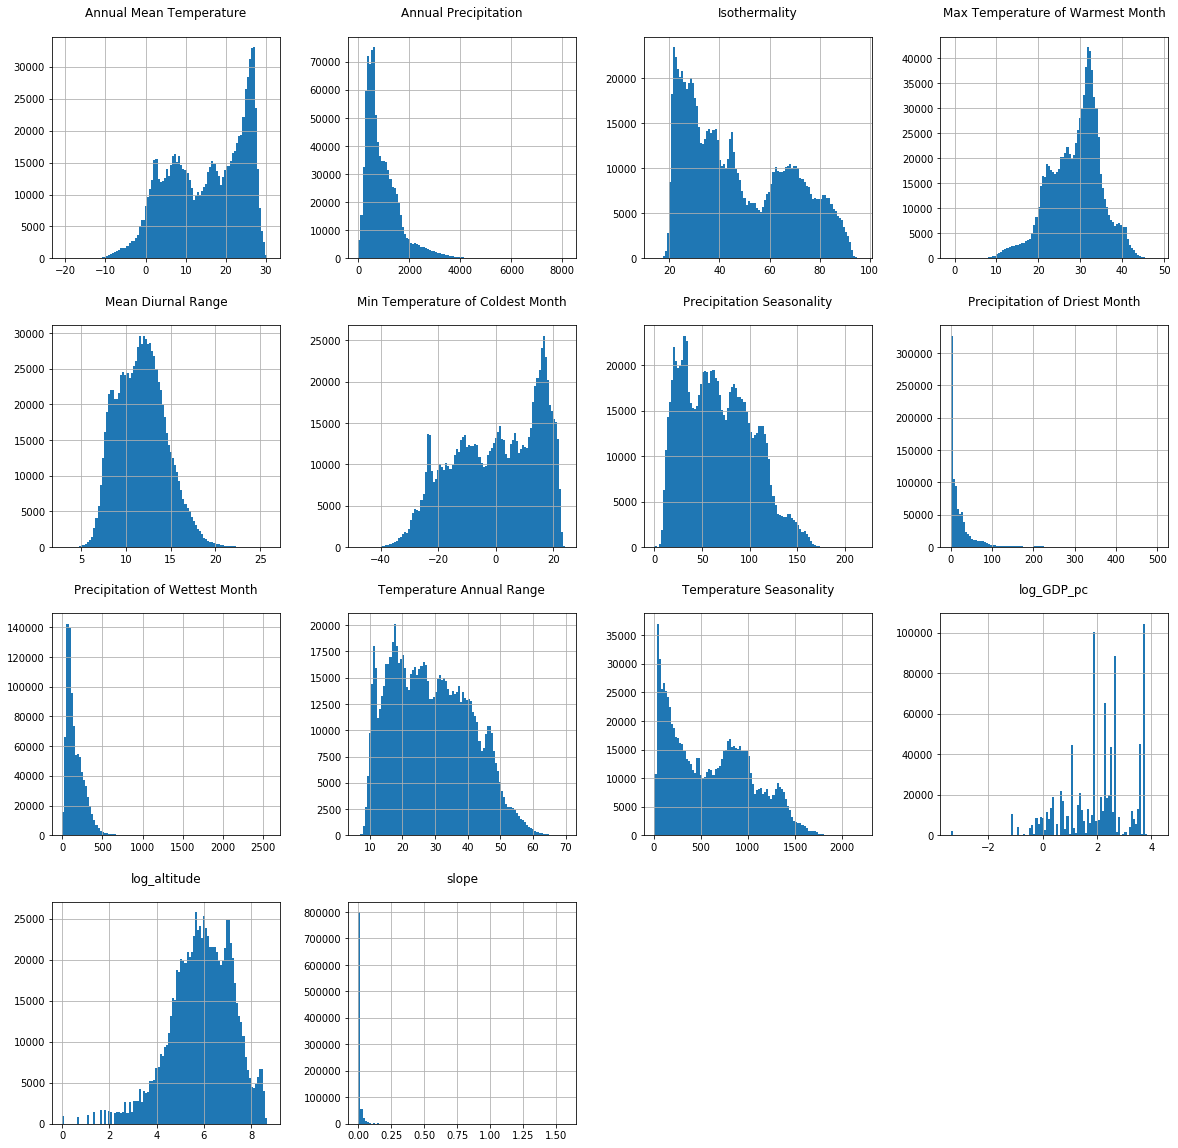

In [9]:
original_df_inputs_light.hist(bins=100, figsize=(20, 20));

#### Standardize the numerical data

In [10]:
scaled_features = StandardScaler().fit_transform(original_df_inputs_light.values)
normalized_df_inputs_light = pd.DataFrame(scaled_features, index=original_df_inputs_light.index, columns=original_df_inputs_light.columns)
normalized_df_light = normalized_df_inputs_light.join(original_df['log_calories_per_ha'].apply(lambda val: np.exp(val))).rename(columns={'log_calories_per_ha': 'calories_per_ha'})
normalized_df_light.head()

,slope,Annual Mean Temperature,Mean Diurnal Range,Isothermality,Temperature Seasonality,Max Temperature of Warmest Month,Min Temperature of Coldest Month,Temperature Annual Range,Annual Precipitation,Precipitation of Wettest Month,Precipitation of Driest Month,Precipitation Seasonality,log_altitude,log_GDP_pc,calories_per_ha
pixel_id,,,,,,,,,,,,,,,
1272549,-0.153712,-1.475516,-1.165132,-1.144300,0.809370,-1.712463,-1.131748,0.526939,-0.529362,-0.764694,0.121706,-1.129169,-1.196828,1.169671,8.917904e+09
1276867,-0.044337,-1.450112,-1.237721,-1.168429,0.799264,-1.698018,-1.119329,0.518921,-0.542201,-0.789168,0.093612,-1.125840,-1.494483,1.169671,8.917904e+09
1276868,-0.064637,-1.451916,-1.224713,-1.167594,0.812035,-1.682275,-1.121075,0.529194,-0.552186,-0.781010,0.093612,-1.105056,-1.509879,1.169671,8.917905e+09
1298466,-0.030012,-1.373077,-1.550384,-1.245221,0.779140,-1.614431,-0.995415,0.407757,-0.629217,-0.797325,-0.018763,-0.962565,-2.201874,1.169671,8.917906e+09
1298467,-0.027781,-1.386672,-1.462516,-1.218055,0.766783,-1.639913,-1.020789,0.426215,-0.619231,-0.789168,-0.018763,-0.963548,-1.912337,1.169671,8.917904e+09


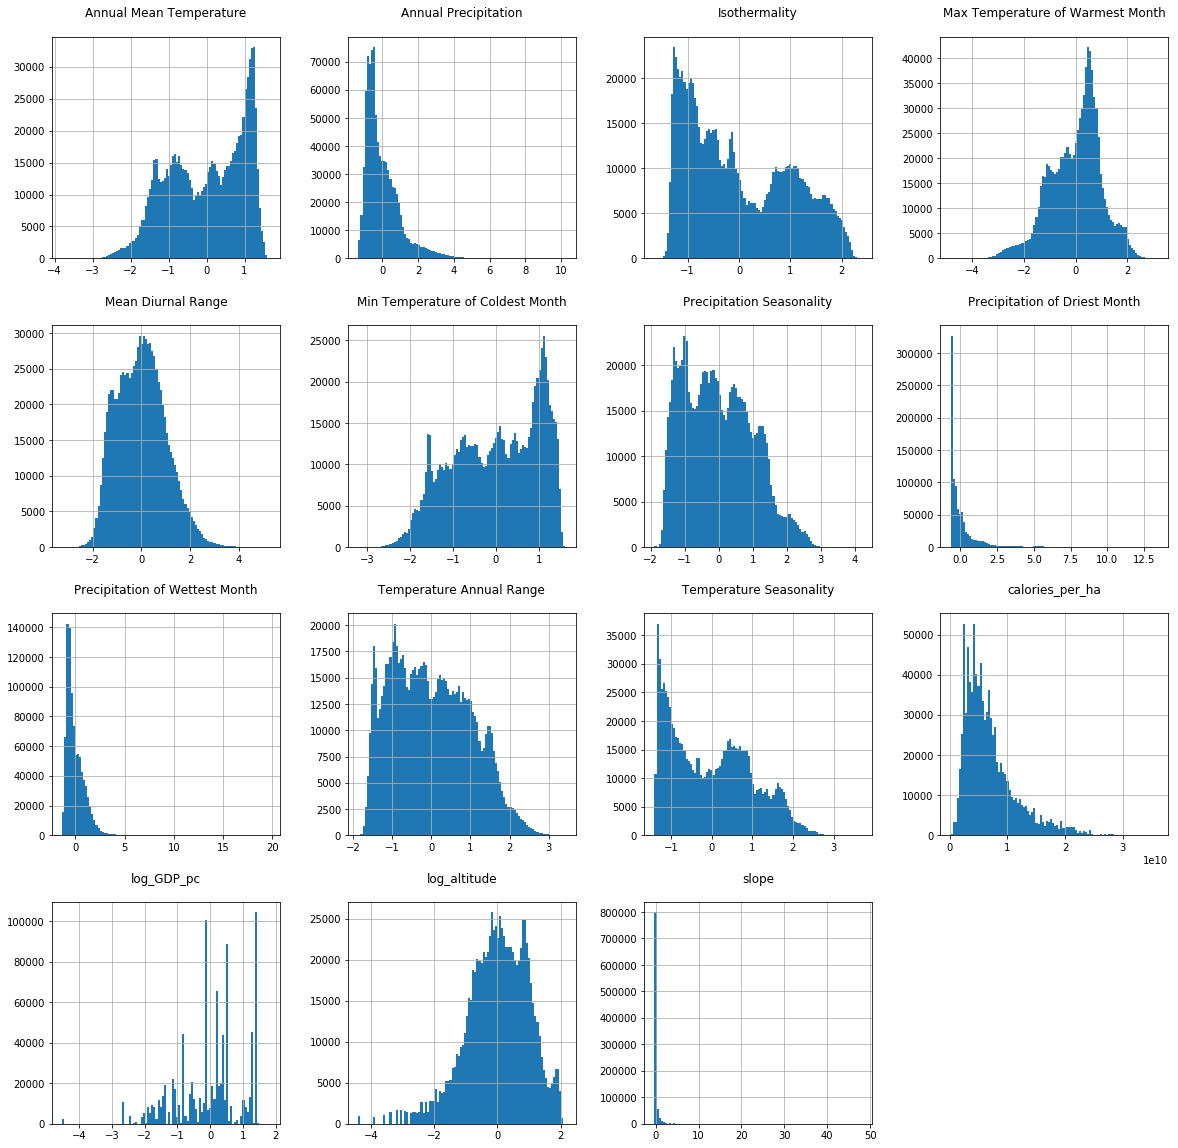

In [11]:
normalized_df_light.hist(bins=100, figsize=(20, 20));

In [12]:
normalized_df_light.describe()

,slope,Annual Mean Temperature,Mean Diurnal Range,Isothermality,Temperature Seasonality,Max Temperature of Warmest Month,Min Temperature of Coldest Month,Temperature Annual Range,Annual Precipitation,Precipitation of Wettest Month,Precipitation of Driest Month,Precipitation Seasonality,log_altitude,log_GDP_pc,calories_per_ha
count,9.067970e+05,9.067970e+05,9.067970e+05,9.067970e+05,9.067970e+05,9.067970e+05,9.067970e+05,9.067970e+05,9.067970e+05,9.067970e+05,9.067970e+05,9.067970e+05,9.067970e+05,9.067970e+05,9.067970e+05
mean,-3.004896e-15,-1.475717e-14,-5.039430e-15,1.531147e-14,5.949798e-15,-5.000453e-15,3.386022e-15,-1.448190e-15,5.866723e-15,-5.923337e-14,1.228624e-14,6.625585e-15,4.028681e-14,7.429875e-13,6.947075e+09
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,4.561124e+09
min,-2.722045e-01,-3.797289e+00,-3.244854e+00,-1.644344e+00,-1.406591e+00,-4.845274e+00,-3.205529e+00,-1.868545e+00,-1.345314e+00,-1.335746e+00,-6.649204e-01,-1.883728e+00,-4.400427e+00,-4.511134e+00,1.305459e+08
25%,-2.460045e-01,-8.473939e-01,-7.750939e-01,-8.989886e-01,-9.354600e-01,-6.829628e-01,-8.101485e-01,-8.530411e-01,-6.991145e-01,-6.994309e-01,-5.806390e-01,-8.758742e-01,-6.108972e-01,-6.311486e-01,3.722623e+09
50%,-1.902927e-01,1.341138e-01,-2.078917e-02,-2.211039e-01,-7.680734e-02,1.629707e-01,9.752513e-02,-9.084923e-02,-3.096832e-01,-2.996947e-01,-3.558885e-01,-9.238051e-02,6.199359e-02,2.197999e-01,5.700472e+09
75%,-5.358575e-02,9.447099e-01,6.677370e-01,8.811098e-01,7.510423e-01,6.620584e-01,9.322331e-01,7.729846e-01,4.420762e-01,4.997778e-01,1.498000e-01,7.425399e-01,7.499500e-01,5.126189e-01,8.766609e+09
max,4.799661e+01,1.652555e+00,5.262810e+00,2.380864e+00,3.689219e+00,3.169508e+00,1.621950e+00,3.430132e+00,1.024062e+01,1.969527e+01,1.341008e+01,4.196263e+00,2.151983e+00,1.811973e+00,3.603413e+10


#### Euclidean distances of random pairs of feature vectors

In [13]:
diff = (np.array(shuffle(normalized_df_inputs_light)) - np.array(shuffle(normalized_df_inputs_light)))
distances = np.linalg.norm(diff, axis=1)
print('Average Eucledian distance: {:.4f}'.format(distances.mean()))
print('Median Eucledian distance: {:.4f}'.format(np.median(distances)))

Average Eucledian distance: 4.8458
Median Eucledian distance: 4.6856


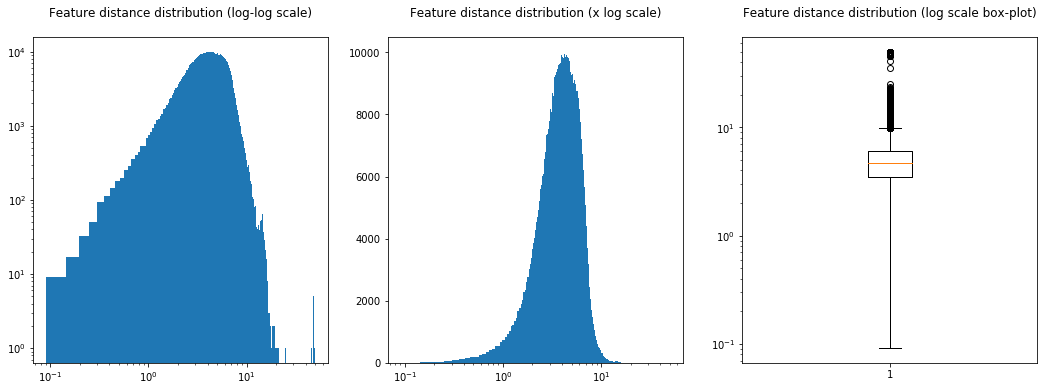

In [14]:
# distance distribution
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(distances, bins='auto')
plt.xscale('log')
plt.yscale('log')
plt.title('Feature distance distribution (log-log scale)')

plt.subplot(1, 3, 2)
plt.hist(distances, bins='auto')
plt.xscale('log')
plt.title('Feature distance distribution (x log scale)')

plt.subplot(1, 3, 3)
plt.boxplot(distances)
plt.yscale('log')
plt.title('Feature distance distribution (log scale box-plot)');

#### Calorie distribution

In [15]:
# find average cal per hect diff
diff_cal_per_ha = np.subtract(shuffle(normalized_df_light['calories_per_ha']), shuffle(normalized_df_light['calories_per_ha'])).abs()
print('Mean calories_per_ha difference between two random points: {:,.2f}'.format(diff_cal_per_ha.mean()))

Mean calories_per_ha difference between two random points: 4,731,245,006.68


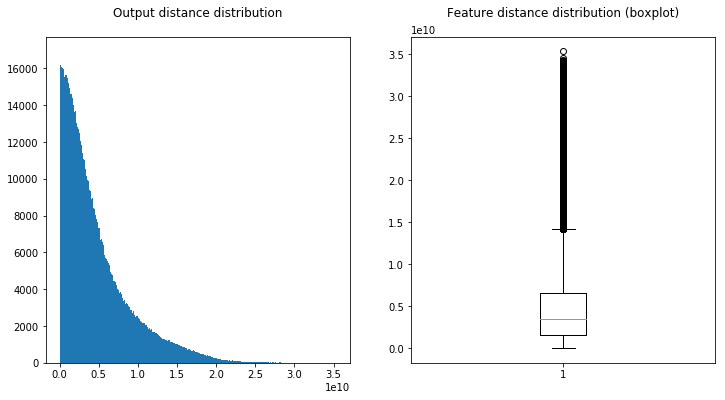

In [16]:
# log_cal_per_ha difference distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(diff_cal_per_ha, bins='auto')
plt.title('Output distance distribution')

plt.subplot(1, 2, 2)
plt.boxplot(diff_cal_per_ha)
plt.title('Feature distance distribution (boxplot)');

#### Feature similarity and yield

In [17]:
# Compute feature and associated log_cal_per_ha distance of random samples
# size represents the number of points to sample: we will have size^2 pairs of points
def compute_trend(size, dataframe):
    df = dataframe
    distances = list()
    cal_diffs = list()
    df_inp = df.drop('calories_per_ha', axis=1)
    for index, row in df_inp.sample(size).iterrows():
        for index2, row2 in df_inp.sample(size).iterrows():
            if(index != index2):
                diff = row - row2
                # round distances to 1 decimal to create bins of 0.1
                dist = round(np.linalg.norm(diff), 1)
                cal_diff = abs(df['calories_per_ha'].loc[index] - df['calories_per_ha'].loc[index2])
                distances.append(dist)
                cal_diffs.append(cal_diff)
    per_similarity = pd.DataFrame(np.column_stack([distances, cal_diffs]), columns=['distance', 'cal_diff'])
    return per_similarity

In [ ]:
# Long to run
similarity = compute_trend(2000, normalized_df_light)

In [32]:
# Used to plot the result of the compute_trend() function
# The threshold represents the maximun distance that we wish to show (we want to sudy only similar points)
def plot_trend(per_similarity, threshold=4.5):
    plt.figure(figsize=(12, 8))
    
    ax1 = plt.subplot(1, 2, 1)
    num_points = per_similarity.groupby('distance').count().reset_index()
    num_points = num_points[num_points['distance'] < threshold]
    ax1.bar(num_points['distance'], num_points['cal_diff'])
    ax1.set_xlabel('Feature distance')
    ax1.set_ylabel('Number of samples')
    ax1.set_title('Samples distance distribution')
    
    ax2 = plt.subplot(1, 2, 2)
    sns.lineplot(x='distance', y='cal_diff', data=per_similarity[per_similarity['distance'] < threshold], ax=ax2)
    ax2.set_xlabel('Feature distance')
    ax2.set_ylabel('Mean calories_per_ha difference')
    ax2.set_title('Output distance in terms of feature distance with 95% CI')
    
    plt.savefig(figure_path + 'feature_output_distances.png')

In [ ]:
plot_trend(similarity, 12)

We can observe that more similar points have a more similar output, the difference of output between similar inputs is way smaller than the one of random input features. For similar outputs, the mean calorie difference sits below the overall average.

#### Back with the soil indexes

In [19]:
soil_indexes = ['nutrient_availability_index', 'oxygen_availability_index', 'workability_index', 
                'protected_areas_index', 'nutrient_retention_index', 'toxicity_index',
                'excess_salts_index', 'rooting_conditions_index']
normalized_df_input = normalized_df_inputs_light.join(original_df_inputs[soil_indexes])
normalized_df_input[soil_indexes].describe()

,nutrient_availability_index,oxygen_availability_index,workability_index,protected_areas_index,nutrient_retention_index,toxicity_index,excess_salts_index,rooting_conditions_index
count,906797.000000,906797.000000,906797.000000,906797.000000,906797.000000,906797.000000,906797.000000,906797.000000
mean,1.857892,1.413938,1.685291,0.141244,1.642318,1.183089,1.268935,1.614004
std,1.093121,1.007025,1.200559,0.484391,1.008081,0.847878,0.927900,1.191609
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,1.000000,2.000000,0.000000,2.000000,1.000000,1.000000,2.000000
max,7.000000,7.000000,7.000000,2.000000,7.000000,7.000000,7.000000,7.000000


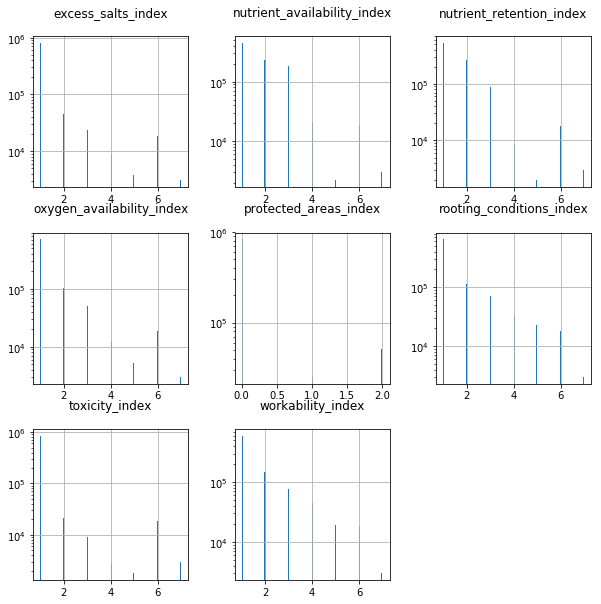

In [20]:
normalized_df_input[soil_indexes].hist(bins=100, figsize=(10, 10), log=True);

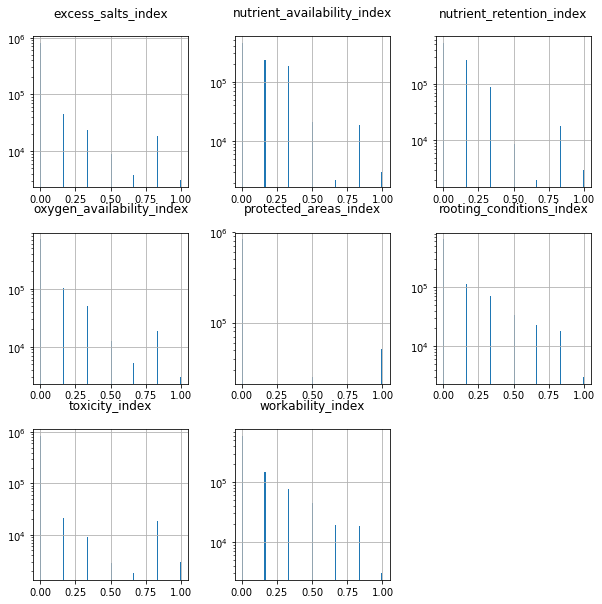

In [21]:
# Normalize the soil indexes
for col in soil_indexes:
    normalized_df_input[col] = normalized_df_input[col] - normalized_df_input[col].min()
    normalized_df_input[col] = normalized_df_input[col] / normalized_df_input[col].max()
normalized_df_input[soil_indexes].hist(bins=100, figsize=(10, 10), log=True);

In [22]:
normalized_df = normalized_df_input.join(normalized_df_light['calories_per_ha'])

sub_df = normalized_df.dropna()
sub_df_input = normalized_df_input.dropna()

In [23]:
diff = np.array(shuffle(sub_df_input)) - np.array(shuffle(sub_df_input))
distances = np.linalg.norm(diff, axis=1)
print('Average Eucledian distance: {:.4f}'.format(distances.mean()))
print('Median Eucledian distance: {:.4f}'.format(np.median(distances)))

Average Eucledian distance: 4.9052
Median Eucledian distance: 4.7456


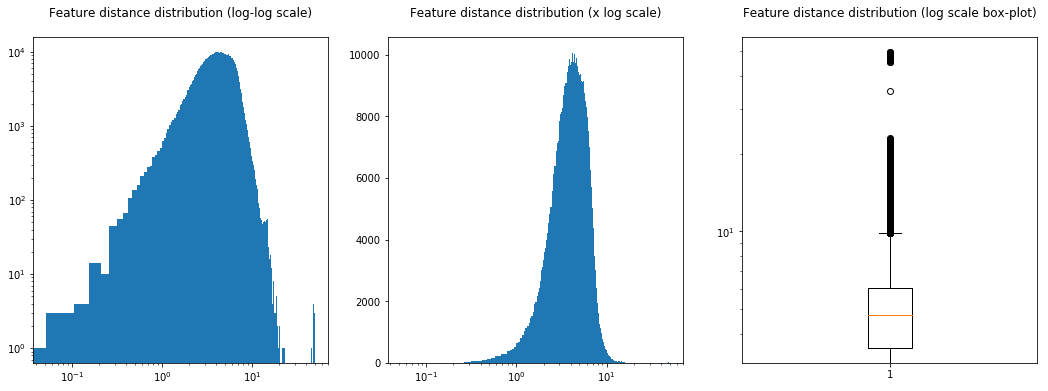

In [24]:
# distance distribution
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(distances, bins='auto')
plt.xscale('log')
plt.yscale('log')
plt.title('Feature distance distribution (log-log scale)')

plt.subplot(1, 3, 2)
plt.hist(distances, bins='auto')
plt.xscale('log')
plt.title('Feature distance distribution (x log scale)')

plt.subplot(1, 3, 3)
plt.boxplot(distances)
plt.yscale('log')
plt.title('Feature distance distribution (log scale box-plot)');

In [ ]:
# Long to run
similarity = compute_trend(2000, sub_df)

In [ ]:
plot_trend(similarity, 12)

#### Back with the fertilizers

Let's now add back the fertilizers features to see if we are able to get the same results of output similarity in terms of land characteristics.

In [25]:
# We do not take 'fertl_c4per' as all of its values are NaN (-9999)
fertilizers = ['fertl_c3ann', 'fertl_c3nfx', 'fertl_c3per', 'fertl_c4ann']
normalized_df_input = normalized_df_input.join(original_df_inputs[fertilizers])
normalized_df_input[fertilizers].describe()

,fertl_c3ann,fertl_c3nfx,fertl_c3per,fertl_c4ann
count,906770.000000,906770.000000,906770.000000,906770.000000
mean,55.552998,16.056328,48.153067,59.609234
std,51.116336,23.960472,71.602349,66.746786
min,0.000000,0.000000,0.000000,0.000000
25%,8.709000,1.361000,0.805000,4.812000
50%,41.979000,5.111000,20.643000,32.762001
75%,81.789001,18.271000,53.161999,115.182656
max,297.250000,338.792999,487.140991,604.789001


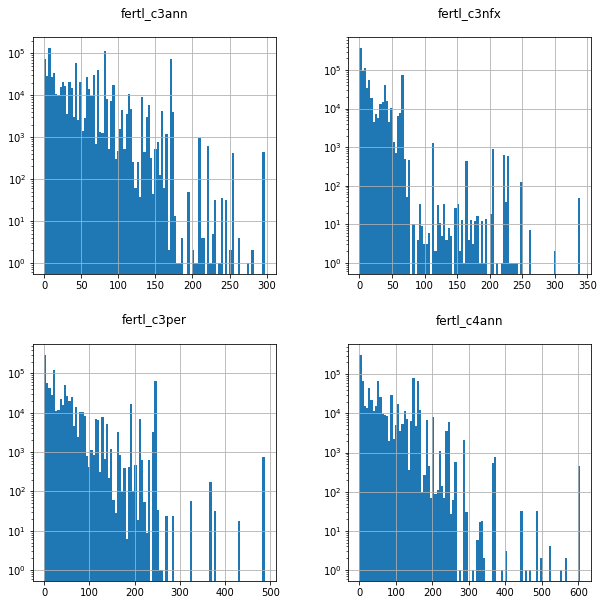

In [26]:
normalized_df_input[fertilizers].hist(bins=100, figsize=(10, 10), log=True);

In [27]:
# Standardize the soil indexes
scaled_fertilizers = StandardScaler().fit_transform(normalized_df_input[fertilizers].values)
normalized_df_input[fertilizers] = scaled_fertilizers

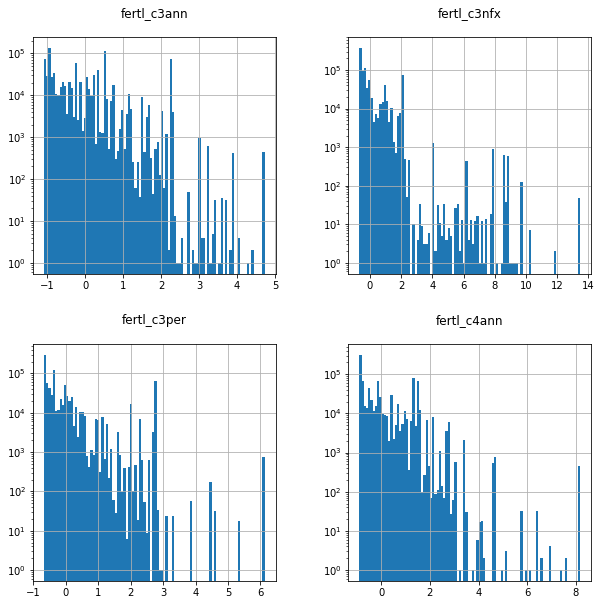

In [28]:
normalized_df_input[fertilizers].hist(bins=100, figsize=(10, 10), log=True);

In [29]:
normalized_df = normalized_df_input.join(normalized_df_light['calories_per_ha'])

sub_df = normalized_df.dropna()
sub_df_input = normalized_df_input.dropna()

In [30]:
diff = np.array(shuffle(sub_df_input)) - np.array(shuffle(sub_df_input))
distances = np.linalg.norm(diff, axis=1)
print('Average Eucledian distance: {:.4f}'.format(distances.mean()))
print('Median Eucledian distance: {:.4f}'.format(np.median(distances)))

Average Eucledian distance: 5.6380
Median Eucledian distance: 5.6156


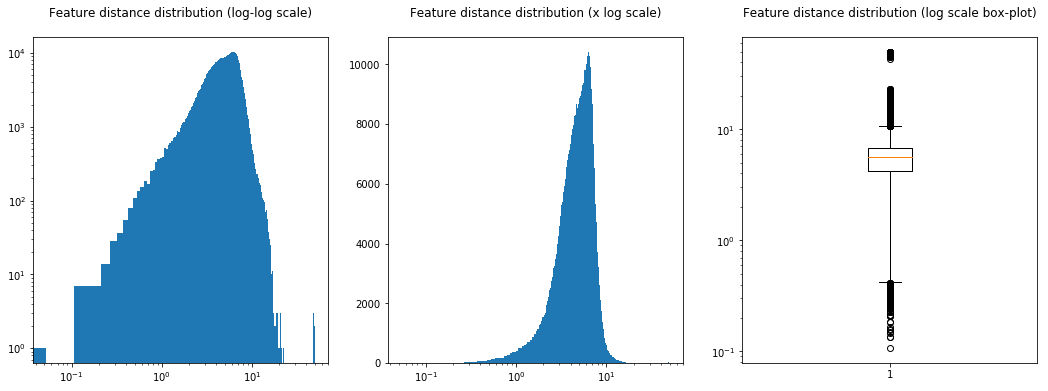

In [31]:
# distance distribution
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(distances, bins='auto')
plt.xscale('log')
plt.yscale('log')
plt.title('Feature distance distribution (log-log scale)')

plt.subplot(1, 3, 2)
plt.hist(distances, bins='auto')
plt.xscale('log')
plt.title('Feature distance distribution (x log scale)')

plt.subplot(1, 3, 3)
plt.boxplot(distances)
plt.yscale('log')
plt.title('Feature distance distribution (log scale box-plot)');

In [33]:
# Long to run
similarity = compute_trend(2000, sub_df)

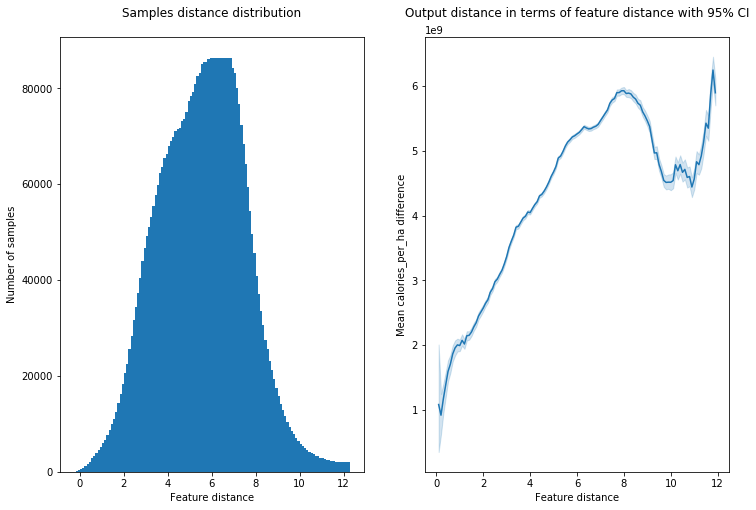

In [34]:
plot_trend(similarity, 12)

In [19]:
normalized_df.to_csv(data_path + 'normalized_2000.csv')

### 1.2. 2000 data: similarity clusters

We now want to see what happens on the output side when we create clusters of points by feature distance and if we can plot the result on a map to see some georaphical separation.

Apply a DBSCAN algorithm to find the different clusters. Use a sample of the data to find the best parameters `eps` and `min_samples`.

In [4]:
normalized_df = pd.read_csv(data_path + 'normalized_2000.csv', index_col='pixel_id')
normalized_df_input = normalized_df.drop('calories_per_ha', axis=1)
normalized_df.head()

,slope,Annual Mean Temperature,Mean Diurnal Range,Isothermality,Temperature Seasonality,Max Temperature of Warmest Month,Min Temperature of Coldest Month,Temperature Annual Range,Annual Precipitation,Precipitation of Wettest Month,...,protected_areas_index,nutrient_retention_index,toxicity_index,excess_salts_index,rooting_conditions_index,fertl_c3ann,fertl_c3nfx,fertl_c3per,fertl_c4ann,calories_per_ha
pixel_id,,,,,,,,,,,,,,,,,,,,,
1272549,-0.153712,-1.475516,-1.165132,-1.144300,0.809370,-1.712463,-1.131748,0.526939,-0.529362,-0.764694,...,1.0,0.166667,0.0,0.0,0.0,0.730178,0.001387,-0.391367,-0.893066,8.917904e+09
1276867,-0.044337,-1.450112,-1.237721,-1.168429,0.799264,-1.698018,-1.119329,0.518921,-0.542201,-0.789168,...,0.0,0.166667,0.0,0.0,0.0,0.730178,-0.670086,-0.672494,-0.893066,8.917904e+09
1276868,-0.064637,-1.451916,-1.224713,-1.167594,0.812035,-1.682275,-1.121075,0.529194,-0.552186,-0.781010,...,0.0,0.333333,0.0,0.0,0.0,0.730178,-0.670086,-0.672494,-0.893066,8.917905e+09
1298466,-0.030012,-1.373077,-1.550384,-1.245221,0.779140,-1.614431,-0.995415,0.407757,-0.629217,-0.797325,...,1.0,0.166667,0.0,0.0,0.0,0.730178,1.344368,0.170901,-0.893066,8.917906e+09
1298467,-0.027781,-1.386672,-1.462516,-1.218055,0.766783,-1.639913,-1.020789,0.426215,-0.619231,-0.789168,...,0.0,0.166667,0.0,0.0,0.0,0.730178,1.344368,0.170901,-0.893066,8.917904e+09


In [5]:
normalized_clustered_input = normalized_df_input.dropna()
normalized_clustered_input.head()

,slope,Annual Mean Temperature,Mean Diurnal Range,Isothermality,Temperature Seasonality,Max Temperature of Warmest Month,Min Temperature of Coldest Month,Temperature Annual Range,Annual Precipitation,Precipitation of Wettest Month,...,workability_index,protected_areas_index,nutrient_retention_index,toxicity_index,excess_salts_index,rooting_conditions_index,fertl_c3ann,fertl_c3nfx,fertl_c3per,fertl_c4ann
pixel_id,,,,,,,,,,,,,,,,,,,,,
1272549,-0.153712,-1.475516,-1.165132,-1.144300,0.809370,-1.712463,-1.131748,0.526939,-0.529362,-0.764694,...,0.0,1.0,0.166667,0.0,0.0,0.0,0.730178,0.001387,-0.391367,-0.893066
1276867,-0.044337,-1.450112,-1.237721,-1.168429,0.799264,-1.698018,-1.119329,0.518921,-0.542201,-0.789168,...,0.0,0.0,0.166667,0.0,0.0,0.0,0.730178,-0.670086,-0.672494,-0.893066
1276868,-0.064637,-1.451916,-1.224713,-1.167594,0.812035,-1.682275,-1.121075,0.529194,-0.552186,-0.781010,...,0.0,0.0,0.333333,0.0,0.0,0.0,0.730178,-0.670086,-0.672494,-0.893066
1298466,-0.030012,-1.373077,-1.550384,-1.245221,0.779140,-1.614431,-0.995415,0.407757,-0.629217,-0.797325,...,0.0,1.0,0.166667,0.0,0.0,0.0,0.730178,1.344368,0.170901,-0.893066
1298467,-0.027781,-1.386672,-1.462516,-1.218055,0.766783,-1.639913,-1.020789,0.426215,-0.619231,-0.789168,...,0.0,0.0,0.166667,0.0,0.0,0.0,0.730178,1.344368,0.170901,-0.893066


In [ ]:
# Test K-means
"""err = []
#sil_scores = []
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k).fit(normalized_clustered_input.values)
    labels = kmeans.labels_
    err.append(kmeans.inertia_)
    #sil_scores.append(silhouette_score(normalized_clustered_input.values, labels, metric='euclidean'))
    unique_labels = np.unique(labels, return_counts=True)
    print(k, dict(zip(unique_labels[0], unique_labels[1])))"""

/Users/Romain/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0, 0.5, 'Intra-cluster variation')

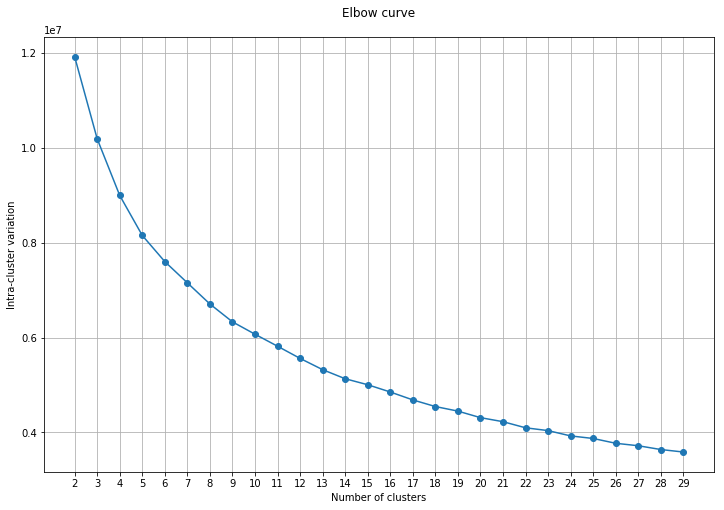

In [35]:
plt.figure(figsize=(12, 8))

plt.grid(True)
plt.title('Elbow curve')

plt.plot(range(2, 30), err, marker='o')
plt.xlabel('Number of clusters')
plt.xticks(range(2, 30))
plt.ylabel('Intra-cluster variation')


In [9]:
# DBSCAN
"""eps, min_samples = 2, 50

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(normalized_clustered_input.values)

labels = dbscan.labels_
unique_labels = np.unique(labels)
print('Number of labels: {}'.format(len(unique_labels)))

normalized_df['label'] = -1
normalized_df.label[normalized_df.notnull().all(axis=1)] = labels
normalized_df['label'].value_counts()"""

In [28]:
clusters = [5, 10, 15, 20]

for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(normalized_clustered_input.values)
    
    normalized_df['label_' + str(k)] = -1
    normalized_df['label_' + str(k)][normalized_df.notnull().all(axis=1)] = kmeans.labels_

"for k in clusters:\n    kmeans = KMeans(n_clusters=k, random_state=0).fit(normalized_clustered_input.values)\n    \n    normalized_df['label_' + str(k)] = -1\n    normalized_df['label_' + str(k)][normalized_df.notnull().all(axis=1)] = kmeans.labels_"

In [87]:
def visualize_clusters(df, k, shape=(2160, 4320), savefig=False):
    
    plt.figure(figsize=(18, 12))
    
    # Set labels to -1
    labels_array = np.zeros((shape[0]*shape[1],)) - 1
    labels_array[df.index] = df['label_' + str(k)].values
    labels_df = pd.DataFrame(labels_array, columns=['label'])
    
    labels = df['label_' + str(k)].unique()
    
    #Colormap
    if k <= 10: cmap = plt.cm.tab10
    else: cmap = plt.cm.tab20b
    cmaplist = [cmap(i) for i in range(cmap.N)][:k]
    cmaplist.insert(0, (1, 1, 1))
    cmap = colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, k+1)
    
    #Plot data
    data = labels_df['label'].values
    bm = Basemap()
    im = bm.imshow(np.flipud(data.reshape(shape)), cmap=cmap)
    bm.drawcoastlines(linewidth=0.15, color='0.1')
        
    plt.title('Cluster visualization ({} clusters)'.format(k))
    cb = plt.colorbar(drawedges=True, fraction=0.02, ticks=None)
    cb.set_label('Labels')
    cb.set_ticks([])
    #plt.show()
  
    if savefig != False:
        plt.savefig(figure_path + 'clusters_map_2000' + '_' + str(k))


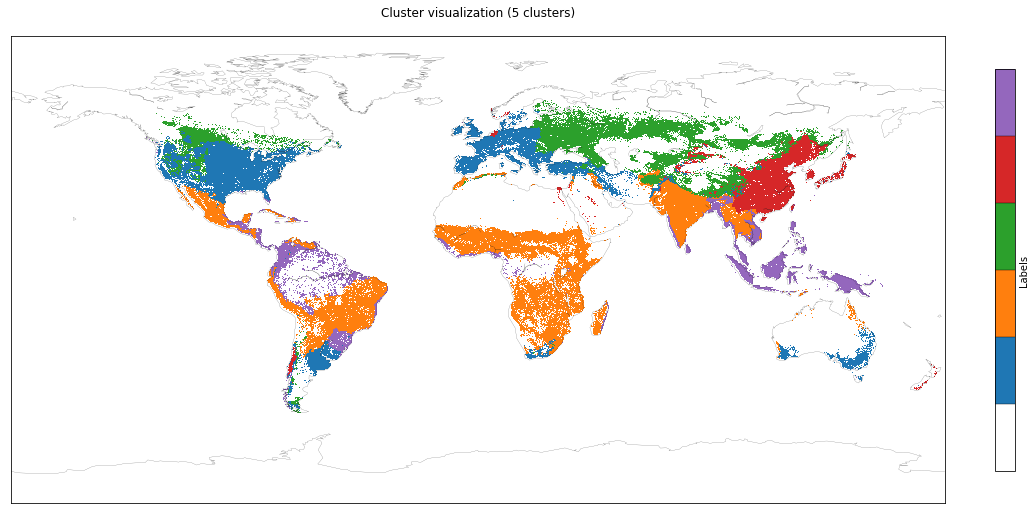

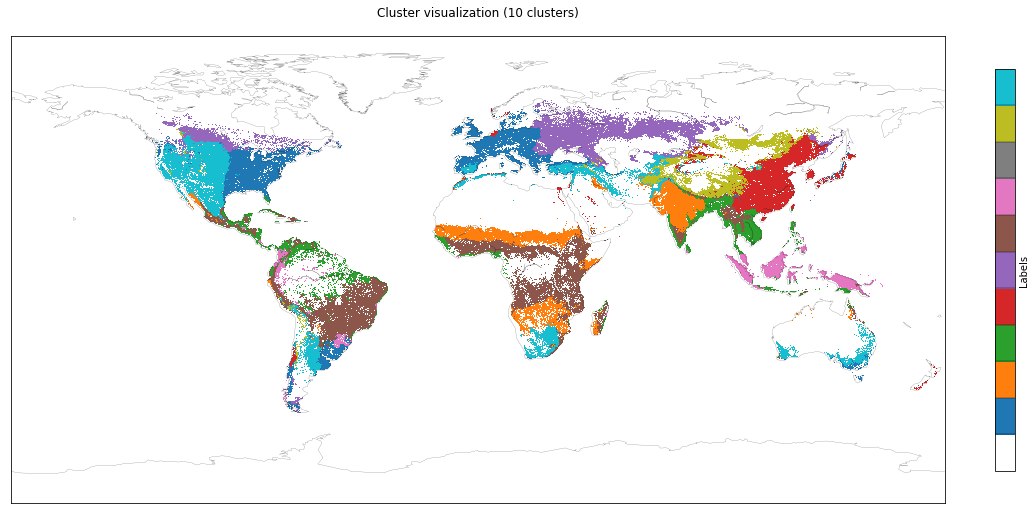

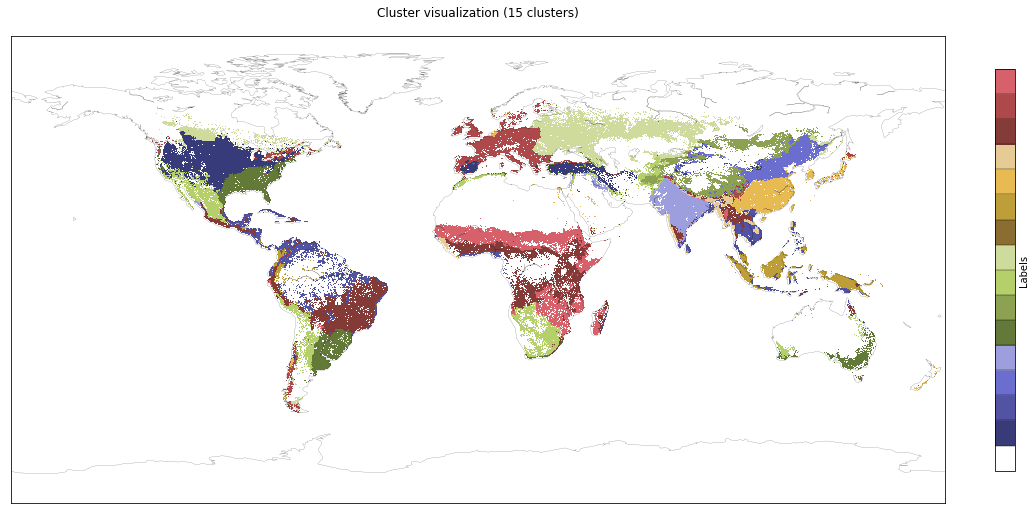

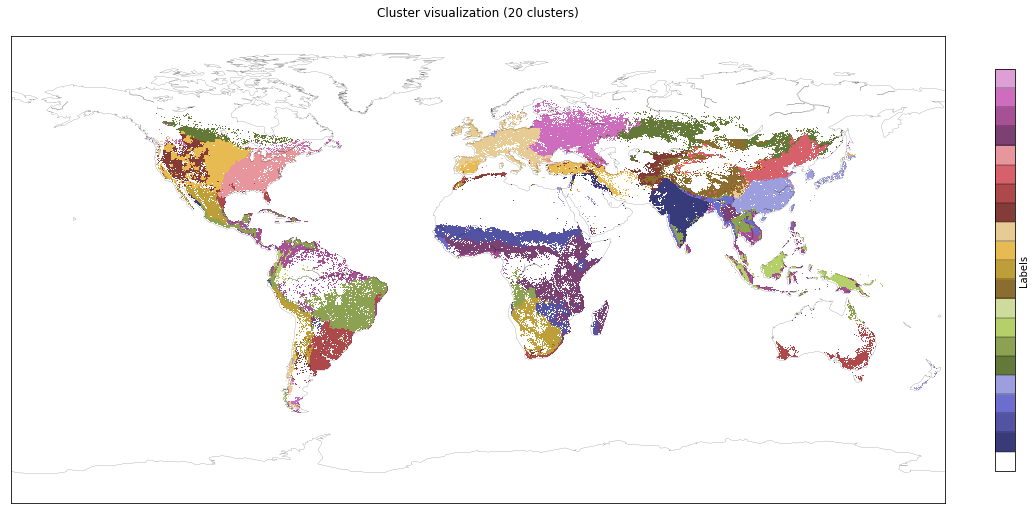

In [89]:
for k in clusters:
    visualize_clusters(normalized_df, k, savefig=False)

In [77]:
normalized_df.to_csv(data_path + 'clustered_2000.csv')